# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations():

    df = pd.read_csv('data/station-locations.csv')

    lons = df['LONGITUDE'].tolist()
    lats = df['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations()

In [2]:
df = pd.read_csv('data/ghcn-daily-subset.csv')
df['Date'] = df['Date'].apply(pd.to_datetime)
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [3]:
pre15 = df[df.Date < '2015']
extrema_pre15 = [((month, day), 
                  date_df[date_df['Element'] == 'TMAX']['Data_Value'].max(), 
                  date_df[date_df['Element'] == 'TMIN']['Data_Value'].min())
                 for (month, day), date_df in pre15.groupby([pre15.Date.dt.month, pre15.Date.dt.day])
                if not (month == 2 and day == 29)]
day_tuples_pre15, highs_pre15, lows_pre15 = zip(*extrema_pre15)
date_ordinals = list(range(len(highs_pre15)))
print(len(highs_pre15))
print(highs_pre15[:5])

365
(156, 139, 133, 106, 128)


In [4]:
# get extremes from 2015 that are greater than extremes from prior years
post15 = df[df.Date >= '2015']
extrema15 = [((month, day), 
              date_df[date_df['Element'] == 'TMAX']['Data_Value'].max(), 
              date_df[date_df['Element'] == 'TMIN']['Data_Value'].min())
             for (month, day), date_df in post15.groupby([post15.Date.dt.month, post15.Date.dt.day])
            if not (month == 2 and day == 29)]
extreme_highs_15 = []
extreme_lows_15 = []
for (day_tuple_pre15, high_pre15, low_pre15), (day_tuple_15, high_15, low_15) in zip(extrema_pre15, extrema15):
    assert day_tuple_pre15 == day_tuple_15 # Same month, day tuple
    if high_15 > high_pre15:
        date_ordinal = day_tuples_pre15.index(day_tuple_15)
        extreme_highs_15.append((date_ordinal, high_15, high_pre15))
    if low_15 < low_pre15:
        date_ordinal = day_tuples_pre15.index(day_tuple_15)
        extreme_lows_15.append((date_ordinal, low_15, low_pre15))

high_date_ordinals_15, highs_15, previous_highs = zip(*extreme_highs_15)
low_date_ordinals_15, lows_15, previous_lows = zip(*extreme_lows_15)
print("Num extreme high days in 2015: {}".format(len(highs_15)))
print("Num extreme low days in 2015: {}".format(len(lows_15)))

Num extreme high days in 2015: 37
Num extreme low days in 2015: 32


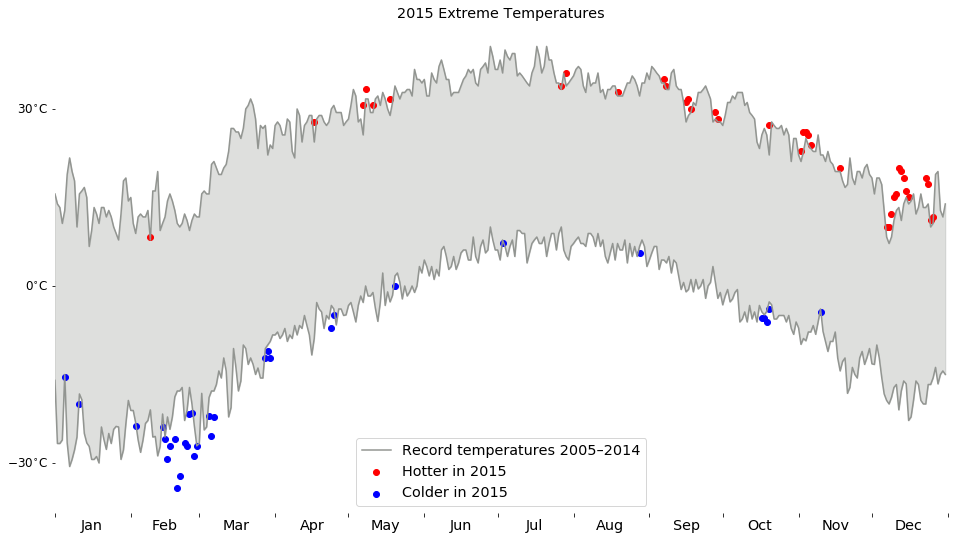

In [5]:
from math import floor

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Plot low and high temps from [2004–2015)
plt.plot(date_ordinals, highs_pre15, date_ordinals, lows_pre15, color='xkcd:grey', label='Record temperatures 2005–2014')
ax.set_xlim(0, 365)

# Fill between plots
plt.fill_between(date_ordinals, highs_pre15, lows_pre15, color='xkcd:grey', alpha=0.3)

# scatter plot 2015 extremes
plt.scatter(high_date_ordinals_15, highs_15, c='r', label='Hotter in 2015')
plt.scatter(low_date_ordinals_15, lows_15, c='b', label='Colder in 2015')

# Tick marks
# First, turn off all but bottom and left ticks and labels
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True)
# Next, set the ticks to the month name, centered under the month
# We do this by setting the major tick marks at month boundaries, but no labels, and
# minor tick marks between months, with month name labels, but no marks
days_in_months = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
major_tick_locs = [sum(days_in_months[:i]) for i in range(1, len(days_in_months)+1)]
minor_tick_locs = [floor((major_tick_locs[i]+major_tick_locs[i+1])/2) for i in range(len(major_tick_locs)-1)]
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(major_tick_locs, [""]*len(month_names))
# ax.set_xticklabels('')
ax.set_xticks(minor_tick_locs, minor=True)
ax.set_xticklabels(month_names, minor=True, fontsize='x-large')
for line in ax.xaxis.get_minorticklines():
    line.set_visible(False)
    
yticks = [-300, 0, 300]
ytick_labels = ['$-30^{\circ}$C', "$0^{\circ}$C", "$30^{\circ}$C"]
plt.yticks(yticks, ytick_labels, fontsize='large')

# Remove bounding box
for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.title("2015 Extreme Temperatures", fontsize='x-large')

# Default legend will have two entries for grey lines, since we plotted it as two series
# So get the default legend and remove the first handle/label
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[1:], labels[1:], loc=8, fontsize='x-large')

plt.show()